# Import Library

In [3]:
# !pip install awswrangler -q

In [2]:
import awswrangler as wr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Load Data

In [3]:
monitor_hist = wr.s3.read_csv('s3://dd-ai-ml/raw_data/preprocessing/parse_data.csv')

## 형변환
monitor_hist['event_date_min'] = pd.to_datetime(monitor_hist['event_date_min'])

## 컬럼명 변경
monitor_hist.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(monitor_hist)]

# Split Train/Test Data

In [4]:
## 학습/테스트 데이터 분류
train_df = monitor_hist[:int(len(monitor_hist) * 0.8)]
test_df = monitor_hist[int(len(monitor_hist) * 0.8):]
print(f"trian_df : {train_df.shape}, {train_df['event_date_min'].min(), train_df['event_date_min'].max()}")
print(f"test_df : {test_df.shape}, {test_df['event_date_min'].min(), test_df['event_date_min'].max()}")

trian_df : (722328, 59), (Timestamp('2021-01-01 00:00:00'), Timestamp('2022-06-02 13:23:00'))
test_df : (180582, 59), (Timestamp('2022-06-02 13:24:00'), Timestamp('2022-10-06 00:00:00'))


# Data PreProcessing

## PreProcessing Module

In [5]:
import pickle

def preprocessing_module(orig_df, single_col, continuous_col):
    df = orig_df.copy()
    
    print(f'Original Data Shape : {df.shape}')
    ## 형변환    
    df.loc[:,'event_date_min'] = pd.to_datetime(df['event_date_min'])    

    ## 컬럼명 변경
    df.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(df)]
        
    ## 단일값 컬럼 제거
    df.drop(single_col, axis = 1, inplace = True)
    print(f'Drop Single Value Columns : {df.shape}')
    
    ## 연속형 변수 보간법
    df.loc[:,continuous_col] = df[continuous_col].interpolate(method = 'polynomial', order=3)
    # df[continuouse_col] = df[continuouse_col].interpolate(method = 'linear')
    
    ## 파생변수 생성 (월, 계절, 시간)
    df.loc[:,'month'] = df['event_date_min'].dt.month
    df.loc[:,'season'] = np.where(df['month'].isin([12,1,2]), 1, ## 겨울
                            np.where(df['month'].isin([3,4,5]), 2, ## 봄
                                     np.where(df['month'].isin([6,7,8]), 3, 4))) ## 여름 / 가을 
    df.loc[:,'hour'] = df['event_date_min'].dt.hour
    print(f'Create Seasonal Value : {df.shape}')
    
    ## 더미변수 생성
    dummy_col = [col for col in list(df) if ('run_status' in col)]
    dummy_col.append('day_night')
    dummy_col.append('month')
    dummy_col.append('hour')
    dummy_col.append('season')
    df = pd.get_dummies(df, columns = dummy_col)
    print(f'Create Dummy Value : {df.shape}')
    return df

def save_pickle(object_name, object_):
    with open(f'{object_name}.pickle','wb') as fw:
        pickle.dump(object_, fw)
        
def read_pickle(object_name):
    with open(f'{object_name}.pickle','rb') as fr:
        object_ = pickle.load(fr)
    return object_

## Data PreProcessing

In [6]:
single_col = read_pickle('single_col')
box_plot_col = read_pickle('box_plot_col')

train_pps = preprocessing_module(train_df, single_col, box_plot_col)
test_pps = preprocessing_module(test_df, single_col, box_plot_col)

Original Data Shape : (722328, 59)
Drop Single Value Columns : (722328, 52)
Create Seasonal Value : (722328, 55)
Create Dummy Value : (722328, 113)
Original Data Shape : (180582, 59)
Drop Single Value Columns : (180582, 52)
Create Seasonal Value : (180582, 55)
Create Dummy Value : (180582, 102)


## Create Target Values

In [7]:
## Create Target Data
## col_n = 10, MSE = 400
target_base = ['sensor_inner_temperature1_1', 'sensor_inner_hum1_1', 'sensor_plantation_temperature_1_1',
          'sensor_plantation_hum_1_1', 'sensor_inner_co2_1', 'sensor_inner_temperature1_2',
          'sensor_inner_hum1_2', 'sensor_plantation_temperature_1_2', 'sensor_plantation_hum_1_2', 'sensor_inner_co2_2',]

target = [col+'_target' for col in target_base]

In [8]:
train_pps[target] = train_pps[target_base].shift(30)
train_pps.reset_index(drop = True, inplace = True)
train_pps.dropna(axis = 0, inplace = True)

test_pps[target] = test_pps[target_base].shift(30)
test_pps.reset_index(drop = True, inplace = True)
test_pps.dropna(axis = 0, inplace = True)

## Split X/Y Data

In [9]:
train_x = train_pps[[col for col in list(train_pps) if col not in target]]
train_x = train_x.select_dtypes(include = ['int64', 'float64'])
train_y = train_pps[[col for col in list(train_pps) if col in target]]

test_x = test_pps[[col for col in list(test_pps) if col not in target]]
test_x = test_x.select_dtypes(include = ['int64', 'float64'])
test_y = test_pps[[col for col in list(test_pps) if col in target]]

## Data Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

scl_model_x = MinMaxScaler()
scl_model_x.fit(train_x)
train_x = scl_model_x.transform(train_x)
test_x = scl_model_x.transform(test_x)

scl_model_y = MinMaxScaler()
scl_model_y.fit(train_y)
train_y = scl_model_y.transform(train_y)
test_y = scl_model_y.transform(test_y)

save_pickle('scl_model_x', scl_model_x)
save_pickle('scl_model_y', scl_model_y)

# Model Test

In [14]:
!pip install xgboost

     |████████████████████████████████| 200.3 MB 9.1 kB/s             B 15.6 MB/s eta 0:00:09
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [15]:
import xgboost
from xgboost import XGBRegressor

In [25]:
xgb_model = XGBRegressor(tree_method = "gpu_hist", seed=1004)
xgb_model = xgb_model.fit(train_x, train_y, eval_metric = 'rmse', eval_set = [(train_x, train_y)], verbose = True, early_stopping_rounds = 100)

[0]	validation_0-rmse:0.14235
[1]	validation_0-rmse:0.10088
[2]	validation_0-rmse:0.07222
[3]	validation_0-rmse:0.05265
[4]	validation_0-rmse:0.03955
[5]	validation_0-rmse:0.03106
[6]	validation_0-rmse:0.02575
[7]	validation_0-rmse:0.02255
[8]	validation_0-rmse:0.02068
[9]	validation_0-rmse:0.01960
[10]	validation_0-rmse:0.01893
[11]	validation_0-rmse:0.01850
[12]	validation_0-rmse:0.01817
[13]	validation_0-rmse:0.01794
[14]	validation_0-rmse:0.01774
[15]	validation_0-rmse:0.01757
[16]	validation_0-rmse:0.01741
[17]	validation_0-rmse:0.01729
[18]	validation_0-rmse:0.01719
[19]	validation_0-rmse:0.01708
[20]	validation_0-rmse:0.01702
[21]	validation_0-rmse:0.01694
[22]	validation_0-rmse:0.01686
[23]	validation_0-rmse:0.01679
[24]	validation_0-rmse:0.01671
[25]	validation_0-rmse:0.01662
[26]	validation_0-rmse:0.01655
[27]	validation_0-rmse:0.01648
[28]	validation_0-rmse:0.01641
[29]	validation_0-rmse:0.01635
[30]	validation_0-rmse:0.01629
[31]	validation_0-rmse:0.01621
[32]	validation_0-

In [ ]:
## Feature Selection 추가


TypeError: only size-1 arrays can be converted to Python scalars

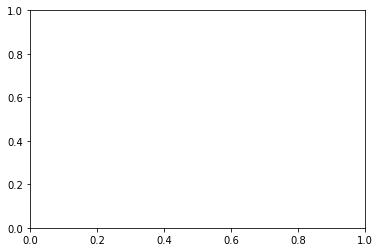

In [41]:
plt.barh(list(train_x), xgb_model.feature_importances_)
plt.show()

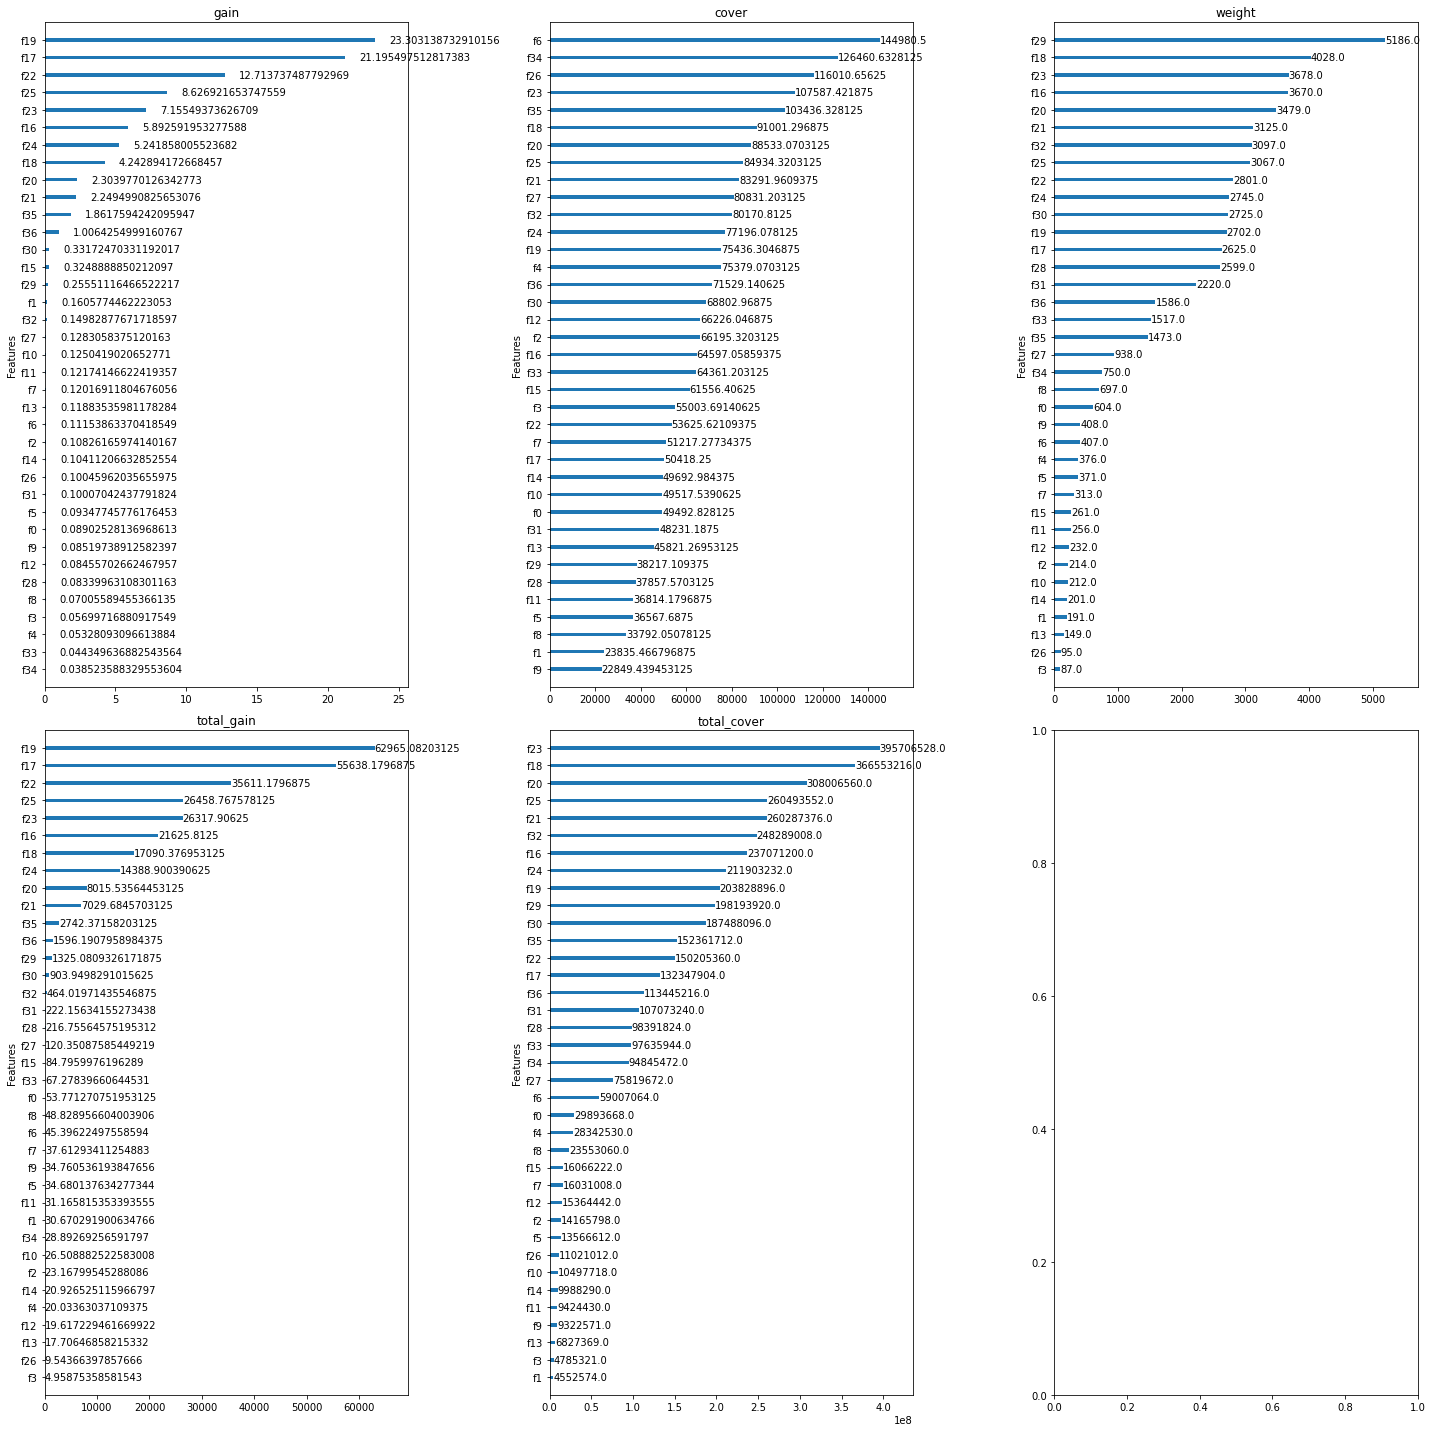

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,20))
axes = [ax for row_axes in axes for ax in row_axes]

xgboost.plot_importance(xgb_model, importance_type = 'gain', title='gain', xlabel = '', grid = False, ax = axes[0])
xgboost.plot_importance(xgb_model, importance_type = 'cover', title='cover', xlabel = '', grid = False, ax = axes[1])
xgboost.plot_importance(xgb_model, importance_type = 'weight', title='weight', xlabel = '', grid = False, ax = axes[2])
xgboost.plot_importance(xgb_model, importance_type = 'total_gain', title='total_gain', xlabel = '', grid = False, ax = axes[3])
xgboost.plot_importance(xgb_model, importance_type = 'total_cover', title='total_cover', xlabel = '', grid = False, ax = axes[4])

plt.tight_layout()
plt.show()


## Train Data Results

TRAIN SCORE
SCALED MSE : 0.0001894197086990339
SCALED RMSE : 0.013762983277583166
MSE : 382.39888500258076
RMSE : 19.55502198931468


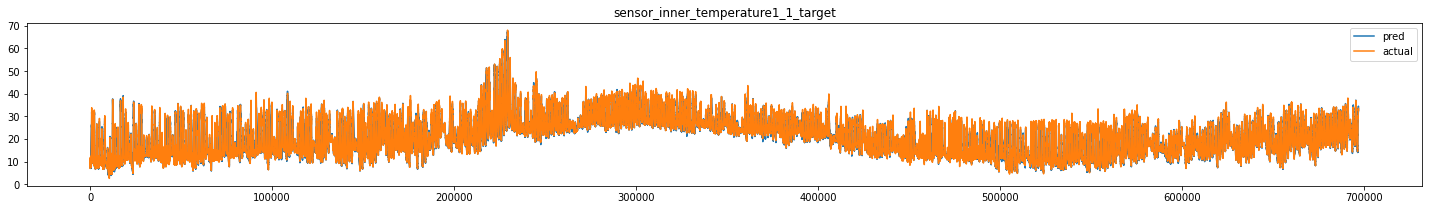

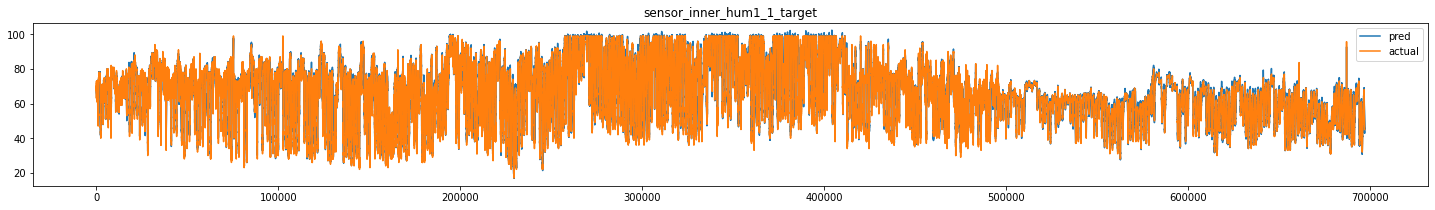

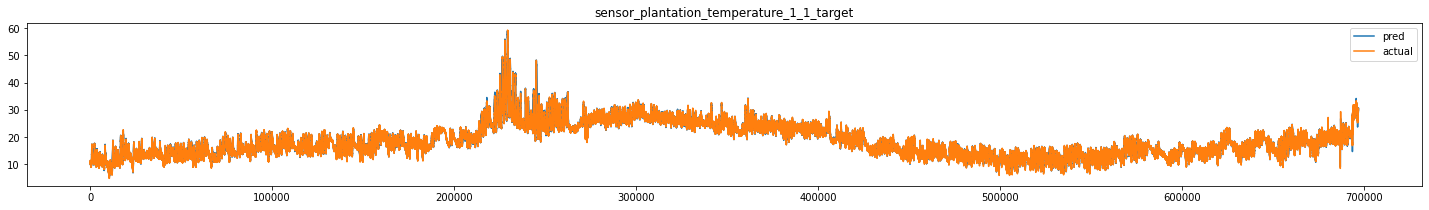

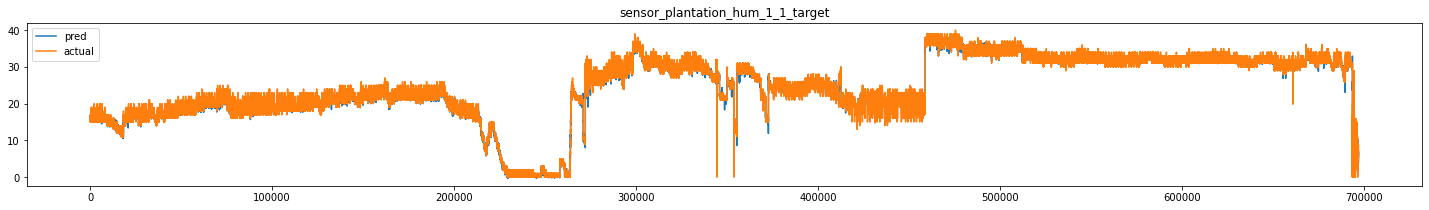

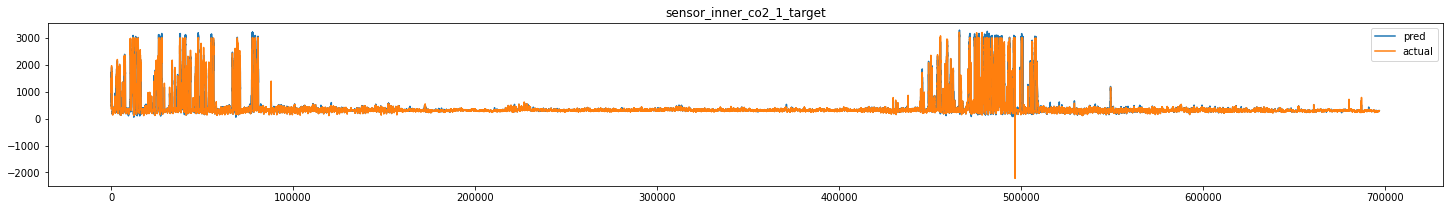

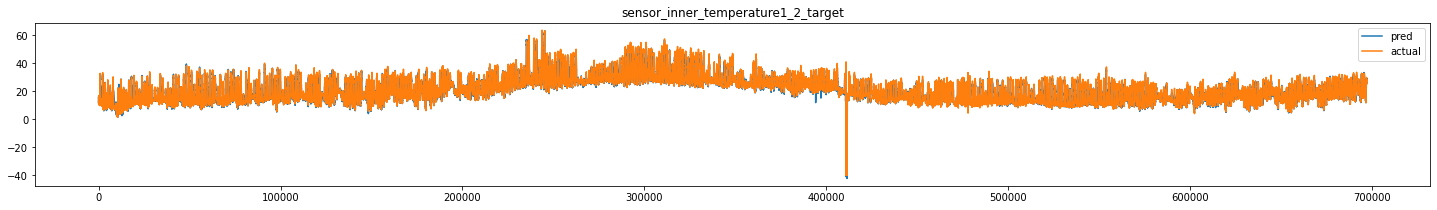

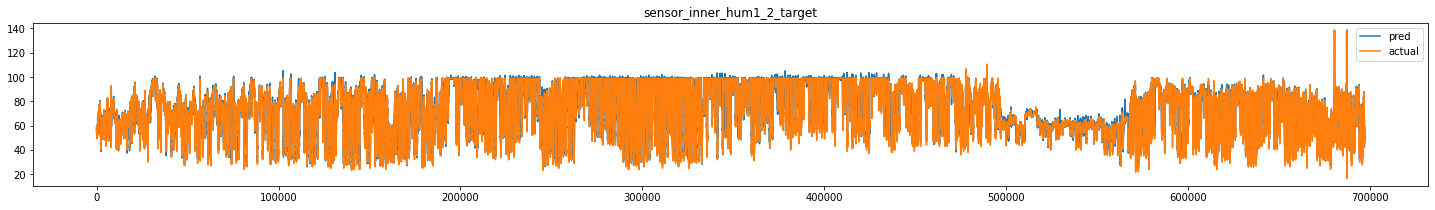

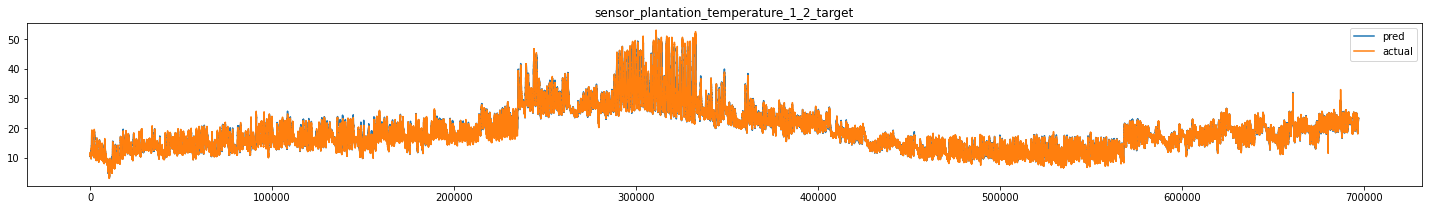

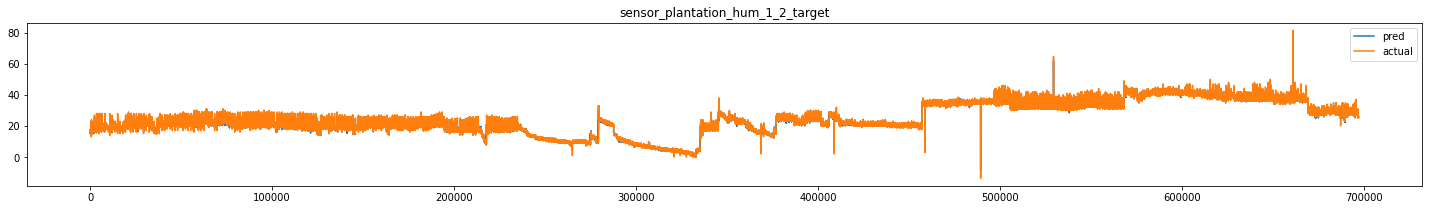

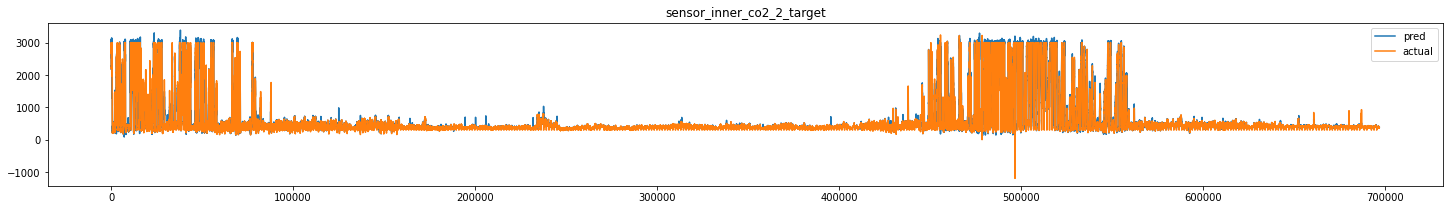

In [28]:
pred = xgb_model.predict(train_x)
actual = train_y

print('TRAIN SCORE') 
print(f'SCALED MSE : {mean_squared_error(actual, pred)}')
print(f'SCALED RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

pred = scl_model_y.inverse_transform(pred)
actual = scl_model_y.inverse_transform(actual)
print(f'MSE : {mean_squared_error(actual, pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

for col in list(pred_df):
    plt.figure(figsize = (25,3))
    plt.plot(pred_df[col])
    plt.plot(actual_df[col])
    plt.legend(['pred','actual'])
    plt.title(col)
    plt.show()

## Test Data Results

TEST SCORE
SCALED MSE : 0.00507921458071086
SCALED RMSE : 0.07126860866265639
MSE : 325.0661051143619
RMSE : 18.029589710094957


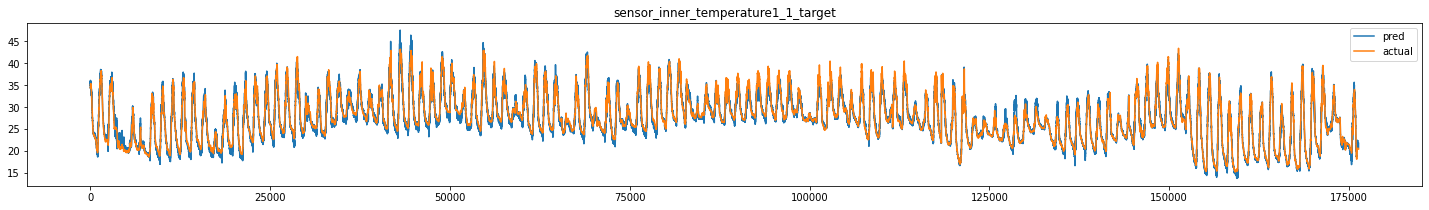

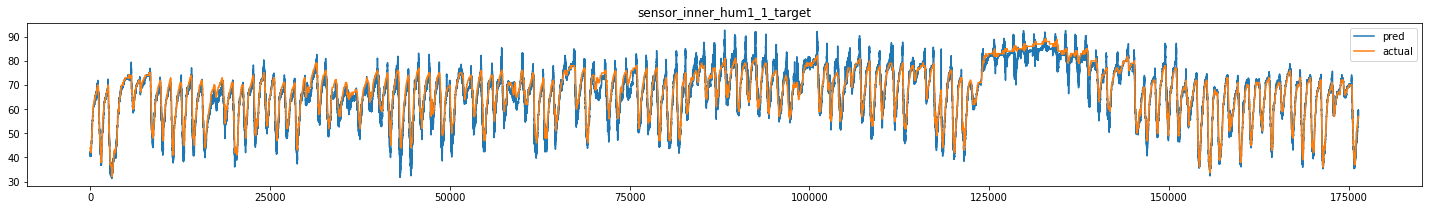

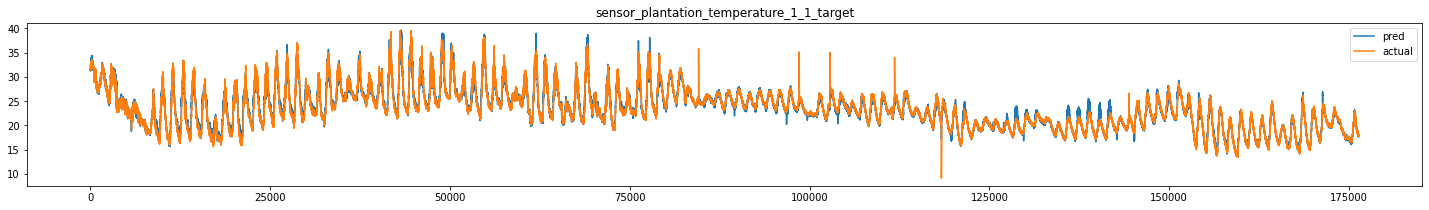

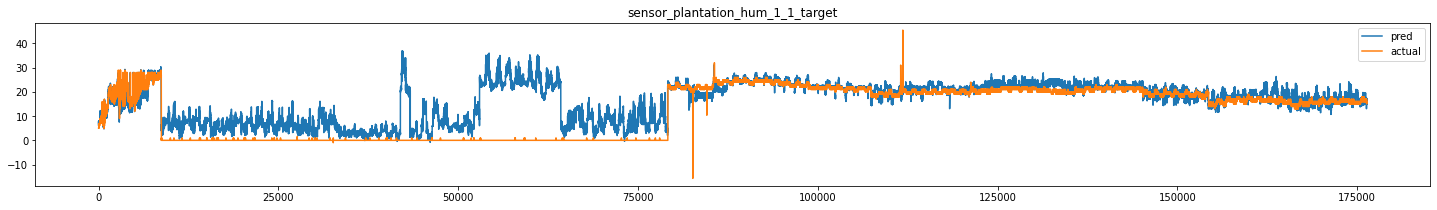

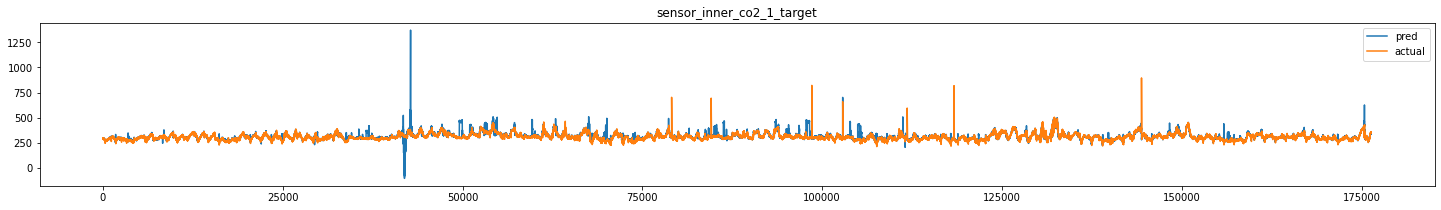

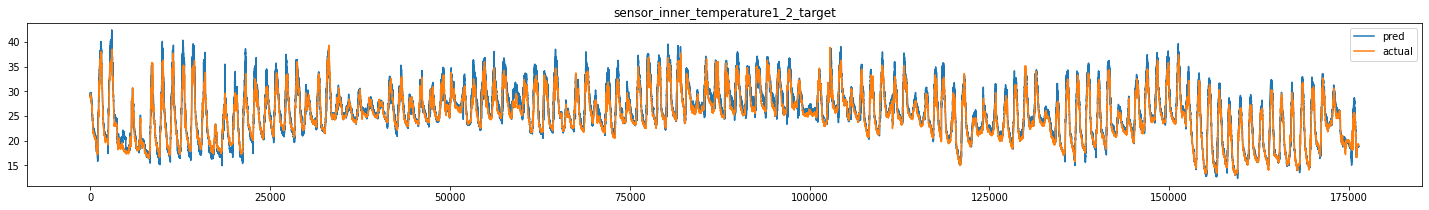

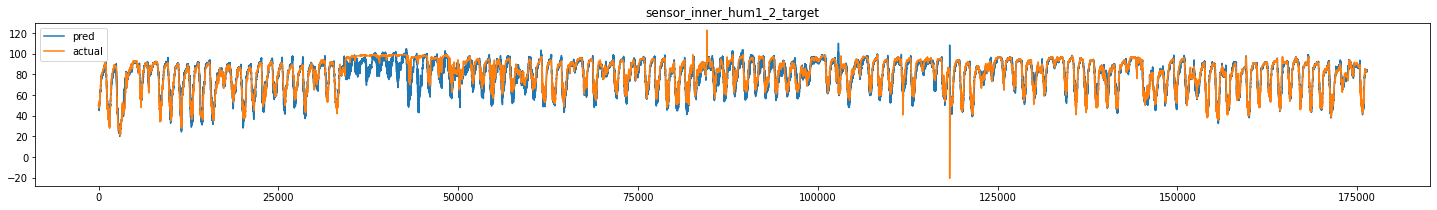

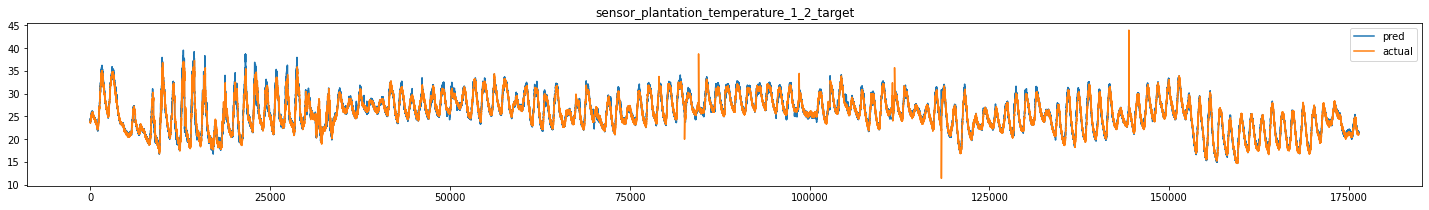

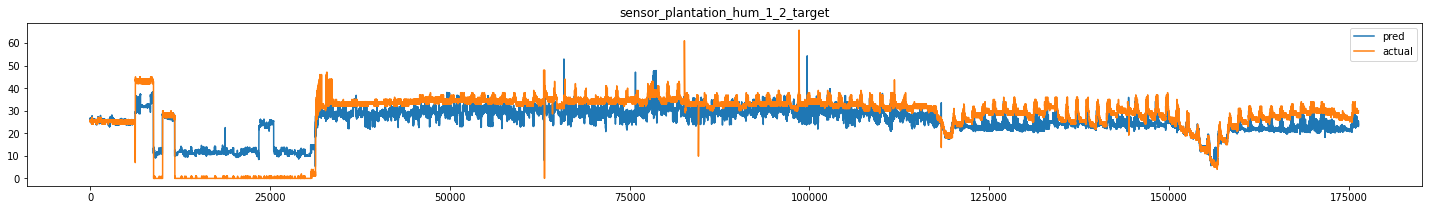

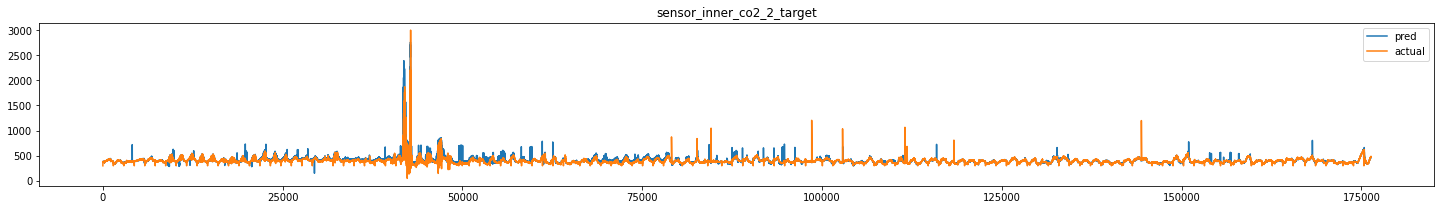

In [29]:
pred = xgb_model.predict(test_x)
actual = test_y

print('TEST SCORE') 
print(f'SCALED MSE : {mean_squared_error(actual, pred)}')
print(f'SCALED RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

pred = scl_model_y.inverse_transform(pred)
actual = scl_model_y.inverse_transform(actual)
print(f'MSE : {mean_squared_error(actual, pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

for col in list(pred_df):
    plt.figure(figsize = (25,3))
    plt.plot(pred_df[col])
    plt.plot(actual_df[col])
    plt.legend(['pred','actual'])
    plt.title(col)
    plt.show()